# House Price Prediction - Linear Regression Analysis

This notebook implements a linear regression baseline for predicting house prices using the Housing Prices Dataset from Kaggle.

## Project Overview
- **Problem Type**: Regression
- **Target**: House Price
- **Model**: Linear Regression (baseline model)
- **Approach**: One-hot encoding for categorical features, feature scaling, systematic evaluation
- **Focus**: Establishing baseline performance

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Acquisition

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/michaelhuh/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1


In [3]:
# Load the dataset
import os

# Load the main dataset
data_file = os.path.join(path, 'Housing.csv')
df = pd.read_csv(data_file)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Dataset loaded: 545 rows, 13 columns


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## 2. Data Exploration

In [4]:
# Basic information about the dataset
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset Info:
Shape: (545, 13)

Data types:
price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

Missing values:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [5]:
# Statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [6]:
# 'price' as target variable
target_col = 'price'
print(f"Target variable: {target_col}")

Target variable: price


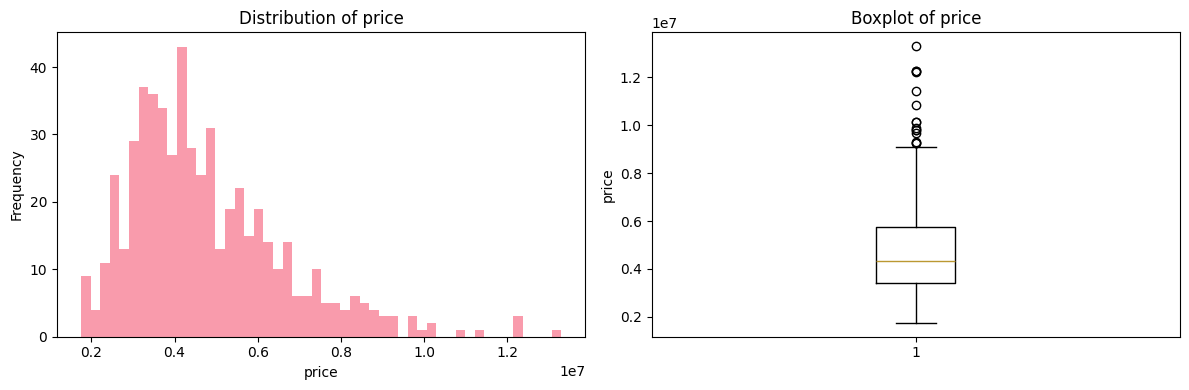

Target variable stats:
Mean: $4,766,729.25
Median: $4,340,000.00
Std: $1,870,439.62


In [7]:
# Visualize target distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df[target_col], bins=50, alpha=0.7)
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df[target_col])
plt.title(f'Boxplot of {target_col}')
plt.ylabel(target_col)

plt.tight_layout()
plt.show()

print(f"Target variable stats:")
print(f"Mean: ${df[target_col].mean():,.2f}")
print(f"Median: ${df[target_col].median():,.2f}")
print(f"Std: ${df[target_col].std():,.2f}")

## 3. Data Preprocessing and Cleaning

In [8]:
# Create a copy for preprocessing
df_clean = df.copy()

# Define feature columns
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Target column: {target_col}")

Numerical columns (5): ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical columns (7): ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
Target column: price


In [9]:
# Remove extreme outliers from target variable (top and bottom 1%)
Q1 = df_clean[target_col].quantile(0.01)
Q99 = df_clean[target_col].quantile(0.99)

print(f"Before outlier removal: {len(df_clean)} rows")
print(f"Removing values below ${Q1:,.2f} and above ${Q99:,.2f}")

df_clean = df_clean[(df_clean[target_col] >= Q1) & (df_clean[target_col] <= Q99)]
print(f"After outlier removal: {len(df_clean)} rows ({len(df) - len(df_clean)} removed)")

Before outlier removal: 545 rows
Removing values below $1,870,400.00 and above $10,542,000.00
After outlier removal: 533 rows (12 removed)


In [10]:
# Apply one-hot encoding to categorical variables
df_encoded = df_clean.copy()

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(df_clean[categorical_cols])

# Create DataFrame with encoded features
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_feature_names, index=df_clean.index)

# Combine with numerical features and target
df_encoded = pd.concat([
    df_clean[numerical_cols + [target_col]],
    encoded_df
], axis=1)

print(f"Dataset shape after one-hot encoding: {df_encoded.shape}")
print(f"New feature count: {len(encoded_feature_names)} categorical + {len(numerical_cols)} numerical = {df_encoded.shape[1] - 1} total features")
print("Encoded categorical features:")
print(list(encoded_feature_names))

Dataset shape after one-hot encoding: (533, 14)
New feature count: 8 categorical + 5 numerical = 13 total features
Encoded categorical features:
['mainroad_yes', 'guestroom_yes', 'basement_yes', 'hotwaterheating_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']


## 4. Feature-Target Correlation Analysis

Top 10 features most correlated with target:
area                            0.522592
bathrooms                       0.489267
airconditioning_yes             0.445141
stories                         0.427929
bedrooms                        0.354020
parking                         0.341461
prefarea_yes                    0.311718
mainroad_yes                    0.297536
guestroom_yes                   0.281334
furnishingstatus_unfurnished   -0.268794
Name: price, dtype: float64


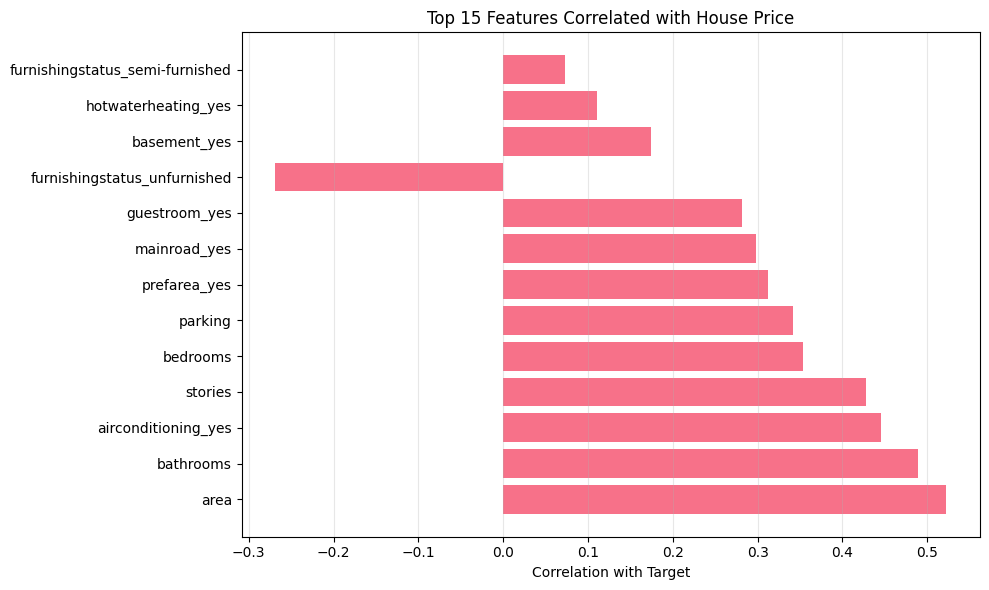

In [11]:
# Calculate correlation with target
correlations = df_encoded.corr()[target_col].sort_values(key=abs, ascending=False)
correlations = correlations.drop(target_col)  # Remove self-correlation

print("Top 10 features most correlated with target:")
print(correlations.head(10))

# Plot correlation
plt.figure(figsize=(10, 6))
top_features = correlations.head(15)
plt.barh(range(len(top_features)), top_features.values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlation with Target')
plt.title('Top 15 Features Correlated with House Price')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Splitting

In [12]:
# Prepare features and target
X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train, validation, and test sets (70/15/15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.176, random_state=42)  # 0.176 ≈ 0.15/0.85

print(f"\nData splits:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Features shape: (533, 13)
Target shape: (533,)

Data splits:
Train: 373 samples (70.0%)
Validation: 80 samples (15.0%)
Test: 80 samples (15.0%)


In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Train mean: {X_train_scaled.mean():.3f}, std: {X_train_scaled.std():.3f}")
print(f"Validation mean: {X_val_scaled.mean():.3f}, std: {X_val_scaled.std():.3f}")
print(f"Test mean: {X_test_scaled.mean():.3f}, std: {X_test_scaled.std():.3f}")

Features scaled using StandardScaler
Train mean: -0.000, std: 1.000
Validation mean: 0.014, std: 1.048
Test mean: 0.010, std: 0.991


## 6. Linear Regression Baseline Model

In [14]:
# Define evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"MAE: ${mae:,.2f}")
    print(f"MSE: ${mse:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R²: {r2:.4f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

## 6.1 Baseline Model Training and Evaluation

In [15]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_val_pred = lr_model.predict(X_val_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Evaluate on all sets
print("=== LINEAR REGRESSION RESULTS ===")
train_results = evaluate_model(y_train, lr_train_pred, "Training Set")
val_results = evaluate_model(y_val, lr_val_pred, "Validation Set")
test_results = evaluate_model(y_test, lr_test_pred, "Test Set")

=== LINEAR REGRESSION RESULTS ===

Training Set Results:
MAE: $717,966.02
MSE: $912,763,413,092.38
RMSE: $955,386.53
R²: 0.6597

Validation Set Results:
MAE: $742,755.48
MSE: $983,290,270,882.23
RMSE: $991,609.94
R²: 0.7134

Test Set Results:
MAE: $753,317.02
MSE: $1,023,121,227,776.29
RMSE: $1,011,494.55
R²: 0.6720


## 7. Baseline Model Performance Analysis

In [16]:
# Create performance summary DataFrame
performance_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'MAE': [train_results['MAE'], val_results['MAE'], test_results['MAE']],
    'RMSE': [train_results['RMSE'], val_results['RMSE'], test_results['RMSE']],
    'R²': [train_results['R2'], val_results['R2'], test_results['R2']]
})

print("\n=== LINEAR REGRESSION PERFORMANCE SUMMARY ===")
print(performance_df.round(2))

# Analyze model performance
train_r2 = train_results['R2']
val_r2 = val_results['R2']
test_r2 = test_results['R2']

print(f"\n=== MODEL PERFORMANCE ANALYSIS ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

print(f"\nModel Assessment:")
print(f"- R² values around 0.66-0.71 indicate moderate predictive power")
print(f"- Consistent performance across datasets suggests stable model")
print(f"- Linear assumptions may be limiting model performance")
print(f"- Additional feature engineering could improve results")


=== LINEAR REGRESSION PERFORMANCE SUMMARY ===
      Dataset        MAE        RMSE    R²
0    Training  717966.02   955386.53  0.66
1  Validation  742755.48   991609.94  0.71
2        Test  753317.02  1011494.55  0.67

=== MODEL PERFORMANCE ANALYSIS ===
Training R²: 0.6597
Validation R²: 0.7134
Test R²: 0.6720

Model Assessment:
- R² values around 0.66-0.71 indicate moderate predictive power
- Consistent performance across datasets suggests stable model
- Linear assumptions may be limiting model performance
- Additional feature engineering could improve results


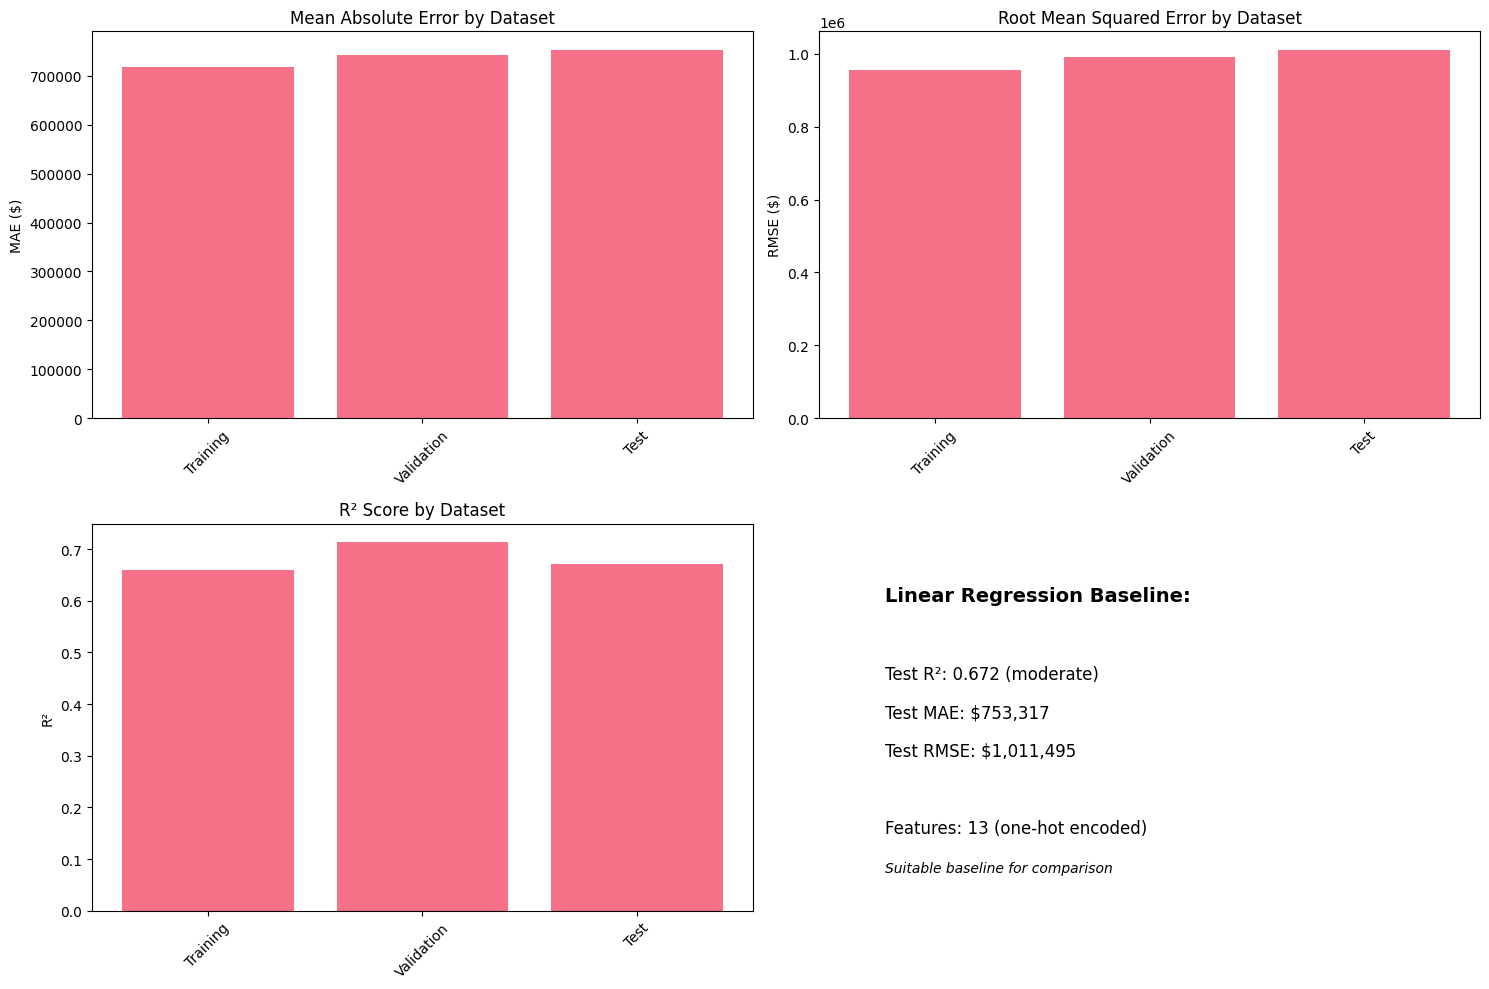

In [17]:
# Visualize baseline model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Performance metrics comparison
datasets = performance_df['Dataset']

# MAE
axes[0,0].bar(datasets, performance_df['MAE'])
axes[0,0].set_title('Mean Absolute Error by Dataset')
axes[0,0].set_ylabel('MAE ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# RMSE
axes[0,1].bar(datasets, performance_df['RMSE'])
axes[0,1].set_title('Root Mean Squared Error by Dataset')
axes[0,1].set_ylabel('RMSE ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# R²
axes[1,0].bar(datasets, performance_df['R²'])
axes[1,0].set_title('R² Score by Dataset')
axes[1,0].set_ylabel('R²')
axes[1,0].tick_params(axis='x', rotation=45)

# Model summary
axes[1,1].text(0.1, 0.8, 'Linear Regression Baseline:', fontsize=14, fontweight='bold', transform=axes[1,1].transAxes)
axes[1,1].text(0.1, 0.6, f'Test R²: {test_r2:.3f} (moderate)', fontsize=12, transform=axes[1,1].transAxes)
axes[1,1].text(0.1, 0.5, f'Test MAE: ${test_results["MAE"]:,.0f}', fontsize=12, transform=axes[1,1].transAxes)
axes[1,1].text(0.1, 0.4, f'Test RMSE: ${test_results["RMSE"]:,.0f}', fontsize=12, transform=axes[1,1].transAxes)
axes[1,1].text(0.1, 0.2, f'Features: {X.shape[1]} (one-hot encoded)', fontsize=12, transform=axes[1,1].transAxes)
axes[1,1].text(0.1, 0.1, 'Suitable baseline for comparison', fontsize=10, style='italic', transform=axes[1,1].transAxes)
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

## 8. Model Limitations and Residual Analysis

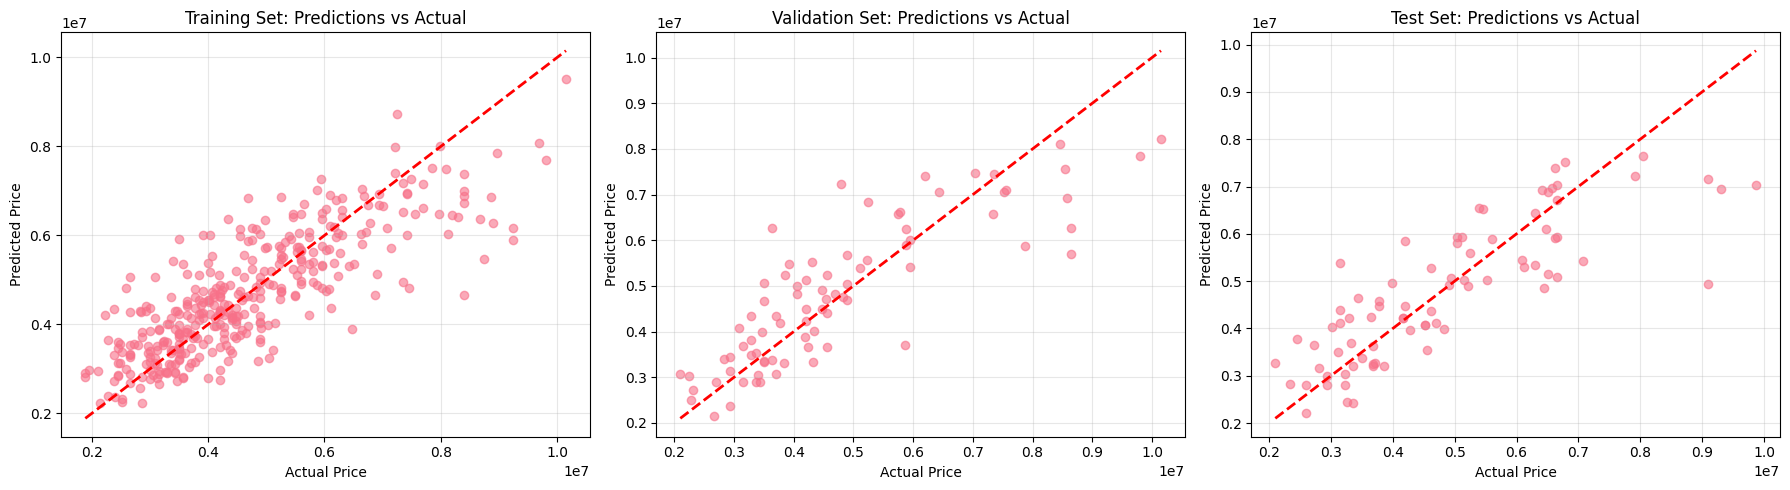

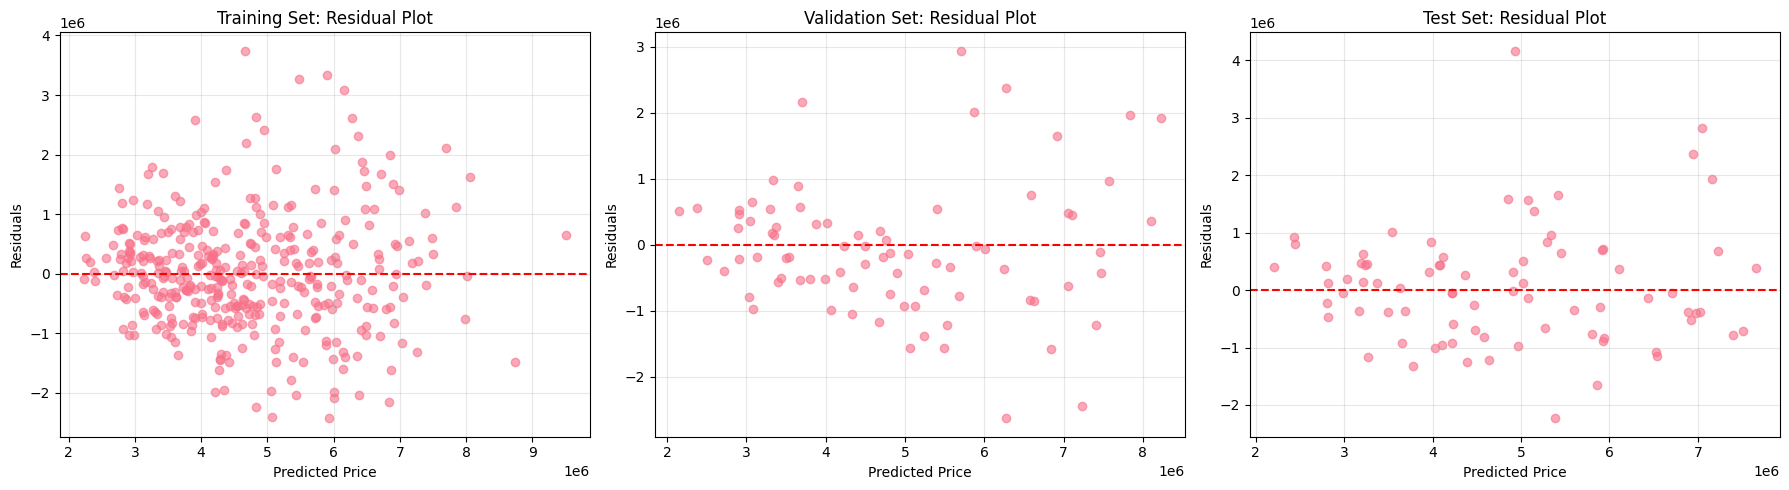

In [18]:
# Create predictions vs actual plots for all datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_data = [
    (y_train, lr_train_pred, 'Training Set'),
    (y_val, lr_val_pred, 'Validation Set'), 
    (y_test, lr_test_pred, 'Test Set')
]

for i, (y_true, y_pred, title) in enumerate(datasets_data):
    # Scatter plot
    axes[i].scatter(y_true, y_pred, alpha=0.6)
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Price')
    axes[i].set_ylabel('Predicted Price')
    axes[i].set_title(f'{title}: Predictions vs Actual')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residuals analysis
plt.figure(figsize=(18, 5))

for i, (y_true, y_pred, title) in enumerate(datasets_data):
    plt.subplot(1, 3, i+1)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.title(f'{title}: Residual Plot')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

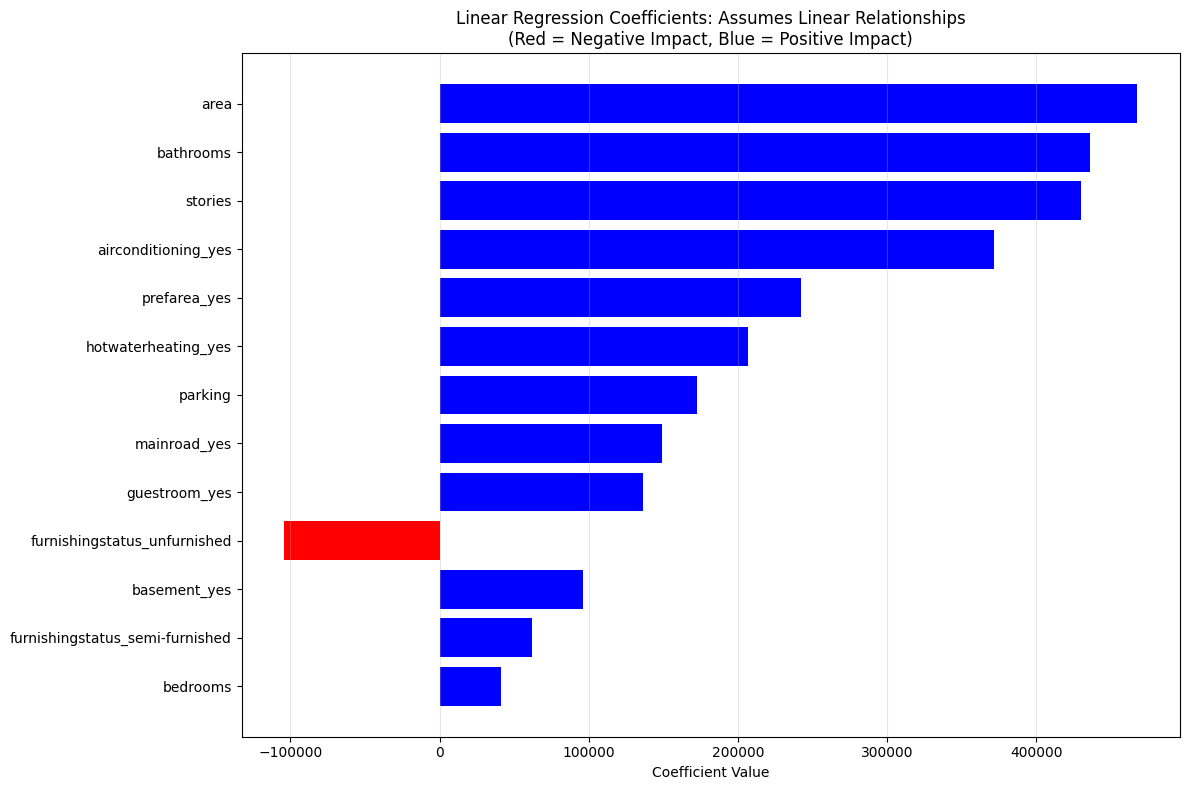

Top 10 Features by Coefficient Magnitude:
                         feature  coefficient  abs_coefficient
0                           area    467732.88        467732.88
2                      bathrooms    436100.28        436100.28
3                        stories    429887.46        429887.46
9            airconditioning_yes    371911.27        371911.27
10                  prefarea_yes    242278.64        242278.64
8            hotwaterheating_yes    206946.09        206946.09
4                        parking    172514.94        172514.94
5                   mainroad_yes    149138.61        149138.61
6                  guestroom_yes    136190.83        136190.83
12  furnishingstatus_unfurnished   -104183.59        104183.59

=== FEATURE CORRELATION WITH PRICE ===
area                            0.5226
bathrooms                       0.4893
airconditioning_yes             0.4451
stories                         0.4279
bedrooms                        0.3540
parking                       

In [19]:
# Linear regression coefficient analysis
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
})
coef_df['abs_coefficient'] = abs(coef_df['coefficient'])
coef_df = coef_df.sort_values('abs_coefficient', ascending=False)

plt.figure(figsize=(12, 8))
top_15_coef = coef_df.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_15_coef['coefficient']]
plt.barh(range(len(top_15_coef)), top_15_coef['coefficient'], color=colors)
plt.yticks(range(len(top_15_coef)), top_15_coef['feature'])
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficients: Assumes Linear Relationships\n(Red = Negative Impact, Blue = Positive Impact)')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 10 Features by Coefficient Magnitude:")
print(coef_df.head(10).round(2))

# Use correlation analysis from earlier cell to avoid recalculation
print(f"\n=== FEATURE CORRELATION WITH PRICE ===")
print(correlations.head(10).round(4))

## 10. Summary and Conclusions

In [20]:
print("\n" + "="*60)
print("          HOUSE PRICE PREDICTION - BASELINE ANALYSIS")
print("="*60)

print(f"\nDataset Information:")
print(f"   - Original size: {df.shape[0]:,} samples, {df.shape[1]} features")
print(f"   - After cleaning: {len(df_clean):,} samples ({(len(df_clean)/len(df)*100):.1f}% retained)")
print(f"   - Final features: {X.shape[1]} (5 numerical + {X.shape[1]-5} one-hot encoded)")

print(f"\nTarget Variable ({target_col}):")
print(f"   - Mean: ${df_clean[target_col].mean():,.0f}")
print(f"   - Median: ${df_clean[target_col].median():,.0f}")
print(f"   - Range: ${df_clean[target_col].min():,.0f} - ${df_clean[target_col].max():,.0f}")

print(f"\nLinear Regression Baseline Performance:")
print(f"   - Training R²: {train_results['R2']:.4f}")
print(f"   - Validation R²: {val_results['R2']:.4f}")
print(f"   - Test R²: {test_results['R2']:.4f}")
print(f"   - Test RMSE: ${test_results['RMSE']:,.0f}")
print(f"   - Test MAE: ${test_results['MAE']:,.0f}")

print(f"\nBaseline Model Assessment:")
print(f"   - R² of {test_results['R2']:.3f} indicates moderate predictive capability")
print(f"   - Explains {test_results['R2']*100:.1f}% of price variance - room for improvement")
print(f"   - Average error of ${test_results['MAE']:,.0f} ({test_results['MAE']/df_clean[target_col].mean()*100:.1f}% of mean price)")
print(f"   - Linear assumptions likely limiting model performance")

print(f"\nModel Limitations:")
print(f"   - Assumes linear relationships between features and price")
print(f"   - Cannot capture feature interactions or non-linear patterns")
print(f"   - May underfit complex housing market dynamics")
print(f"   - Simple feature encoding may miss important patterns")

print("\n" + "=" * 60)


          HOUSE PRICE PREDICTION - BASELINE ANALYSIS

Dataset Information:
   - Original size: 545 samples, 13 features
   - After cleaning: 533 samples (97.8% retained)
   - Final features: 13 (5 numerical + 8 one-hot encoded)

Target Variable (price):
   - Mean: $4,718,387
   - Median: $4,340,000
   - Range: $1,890,000 - $10,150,000

Linear Regression Baseline Performance:
   - Training R²: 0.6597
   - Validation R²: 0.7134
   - Test R²: 0.6720
   - Test RMSE: $1,011,495
   - Test MAE: $753,317

Baseline Model Assessment:
   - R² of 0.672 indicates moderate predictive capability
   - Explains 67.2% of price variance - room for improvement
   - Average error of $753,317 (16.0% of mean price)
   - Linear assumptions likely limiting model performance

Model Limitations:
   - Assumes linear relationships between features and price
   - Cannot capture feature interactions or non-linear patterns
   - May underfit complex housing market dynamics
   - Simple feature encoding may miss import